# Machine Learning Project 'Bank Marketing'

Dataset from a Portuguese bank, based on kaggle:
https://www.kaggle.com/yufengsui/portuguese-bank-marketing-data-set


## Aim:
Predict the likelihood of a positive customer response to a bank’s marketing campaign using collected data, in order to identify which customers should be contacted.

# Initialisation: Import module and set random seeds

In [16]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Model evaluation und visualisation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

# Hyperparameter optimisation
from sklearn.model_selection import GridSearchCV

# to make this notebook's output stable across runs
np.random.seed(42)

# Load and investigate data

In [17]:
marketing_data = pd.read_csv("bank-downsampled.csv")

Before investigating the date, we read the description on Kaggle and the UCI Machine Learning Repository

https://www.kaggle.com/yufengsui/portuguese-bank-marketing-data-set
    
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Also we can use Excel to investigate the data manually

In [18]:
# Investigate data:
marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


We note numerical values for 

> age, balance, day, duration, campaign, pdays and previous,

and 'object' values (usually a string) for

> job, marital, education, default, loan, contact, month, poutcome and deposit

We further investigate the categories (usually booleans and objects) by looking at the value count

In [19]:
cat = ['job','marital','education','default','housing','loan','contact','contact','month','poutcome','deposit'] # can be automated
for c in cat:
    print( c, ':')
    print(marketing_data[c].value_counts() )

job :
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64
marital :
marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64
education :
education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64
default :
default
no     10994
yes      168
Name: count, dtype: int64
housing :
housing
no     5881
yes    5281
Name: count, dtype: int64
loan :
loan
no     9702
yes    1460
Name: count, dtype: int64
contact :
contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64
contact :
contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64
month :
month
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb

In [20]:
# We can investigate the numerals using the "describe" function
marketing_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


## Data insights
We note that the value for "month" is unevenly distributed. Without a clear idea of its meaning, we drop it first

Also based on the description of the dataset, we decide that the duration is not suitable to predict, whether it is worth to call a certain customer.

# Clean the data

In [21]:
marketing_data = marketing_data.drop(['duration','month'], axis=1)
# when removing month from the table, we also need to drop it from the list of categorical features
cat = [item for item in cat if not ( item=='duration' or item=='month' ) ]

# Test-Train split
We avoid further investigation of the full dataset, as it could leak to data leaks. Instead, we split the data and work on training data only.

We do not create a validation set as we use a cross-validation to evaluate the performance during the model selection.

In [22]:
marketing_label = marketing_data['deposit'].copy()
marketing_features = marketing_data.drop('deposit', axis=1)

marketing_features, marketing_features_test, marketing_label, marketing_label_test \
    = train_test_split(marketing_features, marketing_label, test_size=0.3, random_state=42)

In [23]:
print(marketing_features.shape)
print(marketing_label.shape)

(7813, 14)
(7813,)


# Pre-process data:

Fill missing values for numerals

Encode categorical features

In [24]:
# Numerical and categorical features are handled differently, therefore we split them.

# we get the categorical features by removing the deposit from the list of categories (as it's the label)
cat_feature_names = [item for item in cat if not ( item=='deposit' ) ]

marketing_features_num = marketing_features.drop(cat_feature_names, axis=1) 
numerical_feature_names = marketing_features_num.columns

marketing_features_cat = marketing_features[cat_feature_names]

In [25]:
# Categorical features can further be divided in Ordinal and OneHotEncoded features.
# The only feature suitable for an ordinal encoder is 'education'. 
# For good results, we need to manually the desired order of the classes
ordinal_feature_names = ['education']
ordinal_feature_classes = [['unknown', 'primary', 'secondary', 'tertiary']]

one_hot_feature_names = [item for item in cat_feature_names if not item in ordinal_feature_names]


In [26]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.attribute_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [27]:
# counting missing values for each feature:
for i in marketing_data:
    print( i,marketing_data[i].isnull().sum() )

age 0
job 0
marital 0
education 0
default 0
balance 0
housing 0
loan 0
contact 0
day 0
campaign 0
pdays 0
previous 0
poutcome 0
deposit 0


In [28]:
# Impute fills missing numerals by the median of the remaining data
imputer = SimpleImputer(strategy="median")

# The imputer is fit on the training data. It can then also be applied to the test data (without a refit)
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numerical_feature_names)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])

# We run the pipeline to check, whether it runs with no problems
temp = num_pipeline.fit_transform(marketing_features)

In [29]:
# One-Hot-Encoder replaces categorical features by boolean features, stating whether a certain category is true or not
one_hot_pipeline = Pipeline([
        ('selector', DataFrameSelector(one_hot_feature_names)),
        ('one_hot_encoder', OneHotEncoder(drop='first', sparse_output=False))

    ])

# We run the pipeline to check, whether it runs with no problems
temp = one_hot_pipeline.fit_transform(marketing_features)

In [30]:
# OrdinalEncoder replaced categorical features by their position in a list.
ordinal_pipeline = Pipeline([
        ('selector', DataFrameSelector(ordinal_feature_names)),
        ('ordinal_encoder', OrdinalEncoder(categories=ordinal_feature_classes))
    ])

# We run the pipeline to check, whether it runs with no problems
temp = ordinal_pipeline.fit_transform(marketing_features)

In [31]:
#Combine both imputers and get cleaned data

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("one_hot_pipeline", one_hot_pipeline),
        ("ordinal_pipeline", ordinal_pipeline),
    ])
marketing_data_prepared = full_pipeline.fit_transform(marketing_features)

In [32]:
marketing_label = marketing_label.map({'yes':1, 'no':0})
marketing_label_test = marketing_label_test.map({'yes':1, 'no':0})

In [33]:
# Check the size of the data to see the amount of features
print(marketing_data_prepared.shape)

(7813, 30)


# Evaluate models

### Logistic Regression

In [34]:
logistic_regression=LogisticRegression(random_state=42)
logistic_regression.fit(marketing_data_prepared,marketing_label)

LogisticRegression(random_state=42)

In [35]:
predictions = logistic_regression.predict(marketing_data_prepared)
lg_acc = accuracy_score(marketing_label, predictions)
print('Accuracy: ', lg_acc)

Accuracy:  0.6800204786893639


In [36]:
coefs=logistic_regression.coef_[0]                      # coeficient from the classifier
for (a,c) in zip(numerical_feature_names,coefs):    # just the numeric; categorical needs to unpack the one hot encoding
    print('%8s: %5.4f' % (a,c) )

     age: 0.0058
 balance: 0.0804
     day: -0.0412
campaign: -0.2448
   pdays: 0.0419
previous: 0.0190


In [37]:
coefs=logistic_regression.coef_[0][7:20]
jobs=marketing_data['job'].value_counts()
#jobs.index[0]
for (ji,jv,c) in zip(jobs.index,jobs,coefs):    # one-hot-encoding for 'job'
    print('%15s (count %5d): %5.4f' % (ji,jv,c) )

     management (count  2566): -0.3938
    blue-collar (count  1944): -0.3761
     technician (count  1823): -0.0752
         admin. (count  1334): 0.4675
       services (count   923): -0.0865
        retired (count   778): -0.1973
  self-employed (count   405): 0.4352
        student (count   360): -0.1050
     unemployed (count   357): 0.0713
   entrepreneur (count   328): 0.0567
      housemaid (count   274): -0.1706
        unknown (count    70): 0.1535


In [38]:
scores = cross_val_score(logistic_regression, marketing_data_prepared, marketing_label,
                         scoring="accuracy", cv=10)
#
def display_scores(scores):
    print('Mean:%5.4f'%scores.mean())
    print('Standard deviation:%5.4f'%scores.std())
    
display_scores(scores)

Mean:0.6754
Standard deviation:0.0148


### Decision Tree

In [39]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(marketing_data_prepared, marketing_label)

predictions = tree.predict(marketing_data_prepared)
tree_acc = accuracy_score(marketing_label, predictions)
print('%5.4f'%tree_acc)

1.0000


In [40]:
scores = cross_val_score(tree, marketing_data_prepared, marketing_label,
                         scoring="accuracy", cv=10)

In [41]:
display_scores(scores)

Mean:0.5972
Standard deviation:0.0157


### Random Forest

In [42]:
forest = RandomForestClassifier(random_state=42)
forest.fit(marketing_data_prepared, marketing_label)

RandomForestClassifier(random_state=42)

In [43]:
predictions = forest.predict(marketing_data_prepared)
forest_acc = accuracy_score(marketing_label, predictions)
print('%5.4f'%forest_acc)

1.0000


In [44]:
forest_scores = cross_val_score(forest, marketing_data_prepared, marketing_label,
                                scoring="accuracy", cv=10)
display_scores(forest_scores)

Mean:0.6836
Standard deviation:0.0181


### Support Vector Machine

In [45]:
svm = SVC()
%time svm.fit(marketing_data_prepared, marketing_label)
predictions = svm.predict(marketing_data_prepared)
svm_acc = accuracy_score(marketing_label, predictions)
print('%5.4f'%svm_acc)

CPU times: total: 1.8 s
Wall time: 2.21 s
0.7107


In [46]:
%time svm_scores = cross_val_score(svm, marketing_data_prepared, marketing_label, scoring="accuracy", cv=5)
display_scores(svm_scores)

CPU times: total: 8.45 s
Wall time: 9.28 s
Mean:0.6897
Standard deviation:0.0072


### Hyper-parameter optimisation (may take some minutes to run)

In [47]:
param_grid = [
    # try 9 (3×3) combinations of hyperparameters
    {'C': [.1, 1., 10.], 'kernel': ['linear', 'rbf', 'sigmoid']},
    # then try 9 (3×3) combinations for a polynomial kernel
    {'kernel': ['poly'], 'C': [.1, 2., 10.], 'degree': [1, 2, 4]},
  ] # in total 9+9=18 combinations are run

svm = SVC(gamma='scale')
# train across 3 folds, that's a total of 18*3=54 rounds of training 
grid_search = GridSearchCV(svm, param_grid, cv=3,
                           scoring='accuracy', return_train_score=True)
%time grid_search.fit(marketing_data_prepared, marketing_label)

CPU times: total: 2min 15s
Wall time: 2min 33s


GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': [0.1, 1.0, 10.0],
                          'kernel': ['linear', 'rbf', 'sigmoid']},
                         {'C': [0.1, 2.0, 10.0], 'degree': [1, 2, 4],
                          'kernel': ['poly']}],
             return_train_score=True, scoring='accuracy')

In [48]:
grid_search.best_params_ 

{'C': 1.0, 'kernel': 'rbf'}

In [49]:
grid_search.best_estimator_

SVC()

# Evaluation of the final model

In [50]:
final_model = grid_search.best_estimator_


marketing_features_test_prepared = full_pipeline.transform(marketing_features_test)
final_predictions = final_model.predict(marketing_features_test_prepared)


final_acc = accuracy_score(marketing_label_test, final_predictions)
print('%5.4f'%final_acc)

0.6975


## Confusion Matrix & different error types

In [51]:
conf_mat = confusion_matrix(marketing_label_test, final_predictions)
print(conf_mat)

[[1439  303]
 [ 710  897]]


In [52]:
conf_mat_normalised = conf_mat / conf_mat.sum(axis=1, keepdims=True)

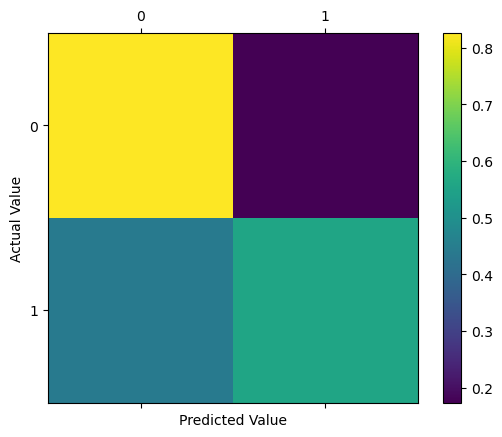

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_normalised)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
fig.colorbar(cax)

# save the figure as this results in a better quality compared to a screenshot
plt.savefig('confusion_matrix.png') # pixel graphic: easier to use in Word
plt.savefig('confusion_matrix.eps') # vector graphic: best quality

# Some notes: 
# To highlight the off-diagonal values, replace the matrix by
#  onf_mat_normalised - np.diag(np.diag(conf_mat_normalised))
# When a gray-scale image is required add
#  cmap='gray'
# to the arguments of ax.matshow

## ROC Curve

In [54]:
final_model.probability = True
# New fit, to compute scores:
final_model.fit(marketing_data_prepared, marketing_label)

SVC(probability=True)

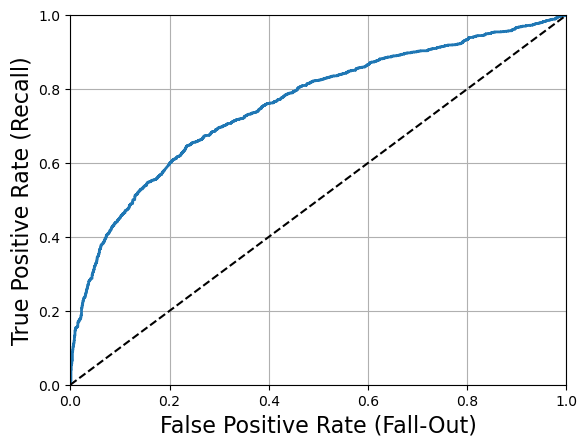

In [55]:
final_predictions_scores = final_model.predict_proba(marketing_features_test_prepared)[:,1]
fpr, tpr, thresholds = roc_curve(marketing_label_test, final_predictions_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)

# save the figure as this results in a better quality compared to a screenshot
plt.savefig('roc.png')
plt.savefig('roc.eps')

Area under the curve:

In [56]:
print(roc_auc_score(marketing_label_test,final_predictions_scores))

0.7581923087639681


## Precision and Recall

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


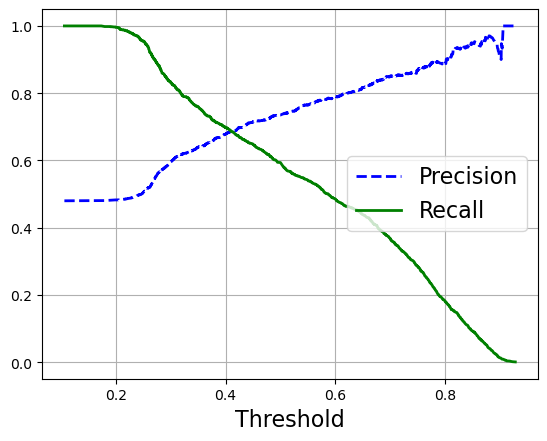

In [57]:
precisions, recalls, thresholds = precision_recall_curve(marketing_label_test, final_predictions_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16) 
plt.grid(True)


# save the figure as this results in a better quality compared to a screenshot
plt.savefig('precision_recall.png')
plt.savefig('precision_recall.eps', format='eps', transparent=False)

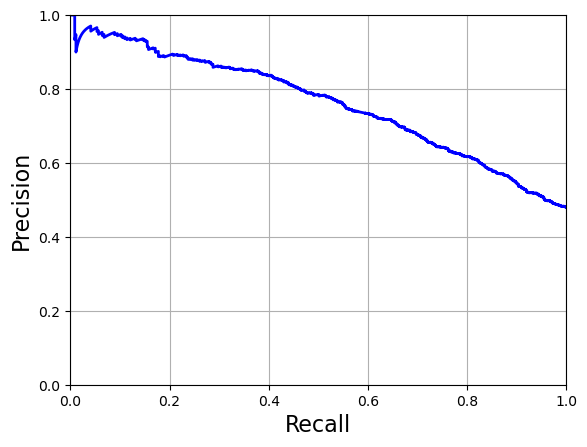

In [58]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)

plt.savefig('precision_recall_2.png')
plt.savefig('precision_recall_2.eps')

# Evaluate Business Case:

### Idea
1 person on the phone, 1 week for the campaign. Customer list made up by the 3349 items of the test set

Estimation: 10min per call (includes preparation), 8hrs per day -> 240 customers can be called

### Business decision

Call the customers with the highest probability score

In [59]:
costumer_predictions = final_predictions_scores
costumer_actual_choice = marketing_label_test.values

In [60]:
# Sort the customers in descending order by their score
index_sort = np.argsort(costumer_predictions)[::-1]
# Note: np.argsort sorts ascending. By inverting the order [::-1], we get a descending order

predictions_sorted = costumer_predictions[index_sort]

In [61]:
customers_sorted = costumer_actual_choice[index_sort]

In [62]:
# The customers are now sorted with descending probability to deposit. 
#  Hence, we will contact the first 240 customers of the list
print('Customers score')
print(predictions_sorted[:240])
print('')
print('Customers actual choice (1 is a success, 0 is unsuccessful):')
outcome_called_customers = customers_sorted[:240]
print(outcome_called_customers)
# the index of these customers can be found in index_sort

Customers score
[0.92841798 0.92337761 0.9214033  0.91940621 0.91868028 0.9123881
 0.91202261 0.91146454 0.91038239 0.91037843 0.90853234 0.90778869
 0.90746172 0.90628616 0.90454153 0.9036378  0.90337579 0.90308455
 0.90303079 0.90257907 0.90221826 0.9017035  0.89953331 0.89891359
 0.89871636 0.89804215 0.89719067 0.8971903  0.89711318 0.89606017
 0.89603587 0.89584134 0.89553646 0.89536352 0.89529607 0.89529582
 0.89476955 0.8941491  0.89298541 0.89253919 0.89236621 0.89160559
 0.89157744 0.89109915 0.88998771 0.88952347 0.88901365 0.88864602
 0.88842996 0.88815964 0.8880059  0.8878699  0.88744176 0.88728545
 0.88704608 0.88644191 0.88629227 0.88575389 0.88417498 0.88395276
 0.88385865 0.88369603 0.88357262 0.88318099 0.88299698 0.88240838
 0.8817503  0.88057852 0.88032107 0.88022996 0.87983878 0.87931885
 0.87845933 0.87833537 0.87830534 0.87828452 0.87815196 0.8776519
 0.87731197 0.87719267 0.87711078 0.877084   0.87695354 0.8765085
 0.87555441 0.87549806 0.87469572 0.87460352 0.87

In [63]:
print('Out of 240 customers, {} have deposited money'.format(sum(outcome_called_customers)))

Out of 240 customers, 224 have deposited money


## Comparison to the baseline model

To interpret the result, we need to compare the result of the prediction with the status quo, i.e. the expected outcome without any data analysis. In this case, we would have called 240 random customers. Let's compare

In [64]:
#240 random customers:
np.random.seed(142)
random_values = np.random.permutation(len(costumer_actual_choice))
customers_random = costumer_actual_choice[random_values]

print('Customers actual choice (1 is a success, 0 is unsuccessful):')
outcome_randomly_called_customers = customers_random[:240]
print(outcome_randomly_called_customers)

Customers actual choice (1 is a success, 0 is unsuccessful):
[0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0
 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0
 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0
 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1
 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0
 0 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1]


In [65]:
print('Without the data analysis, out of 240 customers, {} have deposited money'.
      format(sum(outcome_randomly_called_customers)))

Without the data analysis, out of 240 customers, 123 have deposited money


## Interpretation

This shows the full effect of the data analysis. Instead of 123 customers, 224 would deposit based on our analysis. These are 101 extra customers and an increase of over 80%

# Appendix: Data export

In [66]:
np.savetxt("marketing_prepared.csv", marketing_data_prepared, delimiter=",")
np.savetxt("marketing_labels_num.csv", marketing_label, delimiter=",")
np.savetxt("y_test.csv", marketing_label_test, delimiter=",")
np.savetxt("X_test_prepared.csv", marketing_features_test_prepared, delimiter=",")